# 01. PyTorch Workflow Fundamentals

## What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

For now, we'll use this workflow to predict a simple straight line but the workflow steps can be repeated and changed depending on the problem you're working on.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

## Plans

In [1]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.0.post200'

# 1. Data (preparing and loading)

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets 

We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` tensors.

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.


In [6]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [9]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """Plot training data, test data and compare predictions"""
    plt.figure(figsize=(10, 7))

    # Train by blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Train")

    # Test by green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test")

    if predictions is not None:
        # Predict by red
        plt.scatter(test_data, predictions, c="r", s=4, label="Predict")

    plt.legend()

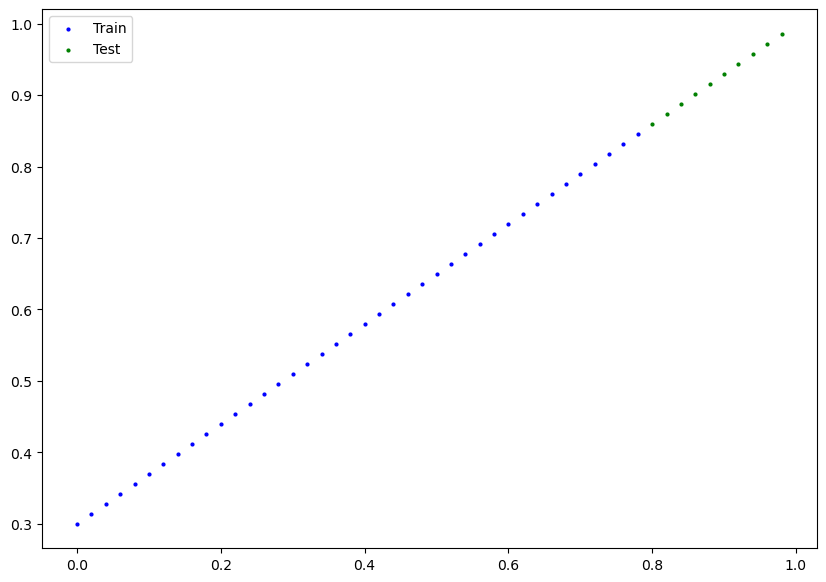

In [10]:
plot_predictions()

## Build Model!

In [11]:
# Linear Regression class
class LinearRegression(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float64), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float64), requires_grad=True)
        # start with random weights (this will get adjusted as the model learns)
        # if i wanna do new parametr -> nn.Parametr()
        # requires_grad -> updates if grad descent AUTOMAT

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """Forward defines the computation in the model"""
        return self.weights * x + self.bias

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their uses cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 
